In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import VotingRegressor


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#!pip install scikit-optimize
#from skopt import BayesSearchCV

In [4]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df_=pd.get_dummies(df, drop_first= True)
df_

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


In [6]:
X=df_.copy().drop('charges', axis=1)
y=df_['charges'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [9]:
rf_regressor = RandomForestRegressor(n_estimators = 5, max_depth=4, bootstrap=True, random_state=1)

from sklearn.model_selection import cross_val_score

rf_regressor.fit(X_train, y_train)
cv_results = cross_val_score(rf_regressor, X_train, y_train, cv=5)
cv_results


array([0.83040446, 0.91062278, 0.8298964 , 0.80192586, 0.84059919])

In [15]:
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

In [11]:
rf_regressor.score(X_train, y_train)

0.8701262030320338

In [12]:
rf_regressor.score(X_test, y_test) # R^2

0.8704070427807703

In [16]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8704070427807703

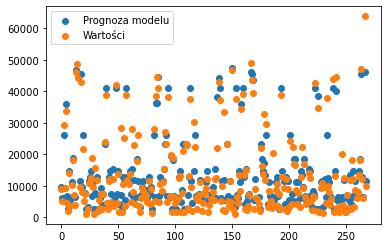

In [17]:

plt.scatter(range(len(y_pred)), y_pred, label = 'Prognoza modelu')
plt.scatter(range(len(y_pred)), y_test, label = 'Wartości')
plt.legend()

In [20]:
import hyperopt
from hyperopt import hp, fmin, tpe
from hyperopt.pyll.base import scope

space_rf = {"max_depth": hp.randint('max_depth', 1, 100),
             "n_estimators": scope.int(hp.qloguniform('n_estimators', 1, 10, 1)),
             "min_samples_leaf": hp.randint('min_samples_leaf', 1, 50),
             "max_features": hp.choice('max_features', ['sqrt', 2, 3, 4, 5, 6, 7, 8]),
             }

def minimize_rf(params):
    max_depth = params["max_depth"]
    max_features = params['max_features']
    min_samples = params['min_samples_leaf']
    n_estimators = int(params['n_estimators'])
    model = RandomForestRegressor(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples, n_estimators=n_estimators)
    mean_cv_score = np.mean(cross_val_score(model, X_train, y_train))
    return -mean_cv_score

print(hyperopt.pyll.stochastic.sample(space_rf))

{'max_depth': array(77, dtype=int64), 'max_features': 8, 'min_samples_leaf': array(34, dtype=int64), 'n_estimators': 740}


In [21]:
best_rf = fmin(minimize_rf, space_rf, max_evals=20, algo=tpe.suggest)
best_rf

100%|██████████| 20/20 [02:57<00:00,  8.87s/trial, best loss: -0.8440250852051314]


{'max_depth': 47,
 'max_features': 3,
 'min_samples_leaf': 6,
 'n_estimators': 365.0}

In [23]:
best_rf_regressor = RandomForestRegressor(n_estimators = 365, max_depth=47, min_samples_leaf=6, random_state=1)
best_rf_regressor.fit(X_train, y_train)
y_pred_best = best_rf_regressor.predict(X_test)
r2_score(y_test, y_pred_best)

0.8787018226585205

In [24]:
importances = best_rf_regressor.feature_importances_

In [28]:
importances

array([0.12342788, 0.1879271 , 0.01058248, 0.00254317, 0.67092025,
       0.00111107, 0.00188355, 0.00160449])

Text(0, 0.5, 'FEATURE NAMES')

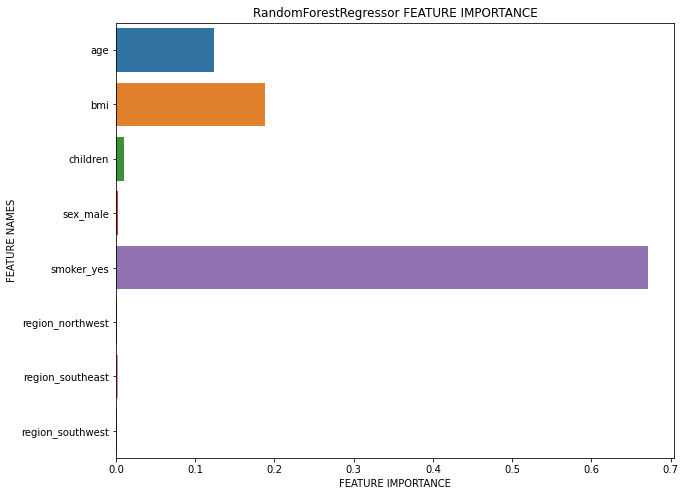

In [36]:
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=importances, y=X.columns)
#Add chart labels
plt.title('RandomForestRegressor ' + 'FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')